<a href="https://www.kaggle.com/code/lonnieqin/isolated-sign-language-recognition-with-convlstm1d?scriptVersionId=120861597" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Isolated Sign Language Recognition with ConvLSTM1D

In this notebook, I will create Sign Language Recognition model using ConvLSTM1D. To build an efficient training pipeline, I will using TFRecord Dataset from https://www.kaggle.com/datasets/lonnieqin/islr-12-time-steps-tfrecords created by notebook https://www.kaggle.com/code/lonnieqin/islr-create-tfrecord for training.

It will take about 1 hour to finish runing this notebook using GPU.

## Configuration

In [1]:
class CFG:
    data_path = "../input/asl-signs/"
    tf_record_path = "../input/islr-12-time-steps-tfrecords/"
    sequence_length = 12
    rows_per_frame = 543
    is_training = False

## Import Libraries

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tqdm import tqdm
import json
import os
from kaggle_datasets import KaggleDatasets

## Utilities

In [3]:
ROWS_PER_FRAME = 543  # number of landmarks per frame

def load_relevant_data_subset_with_imputation(pq_path):
    data_columns = ['x', 'y', 'z']
    data = pd.read_parquet(pq_path, columns=data_columns)
    data.replace(np.nan, 0, inplace=True)
    n_frames = int(len(data) / ROWS_PER_FRAME)
    data = data.values.reshape(n_frames, ROWS_PER_FRAME, len(data_columns))
    return data.astype(np.float16)

def load_relevant_data_subset(pq_path):
    data_columns = ['x', 'y', 'z']
    data = pd.read_parquet(pq_path, columns=data_columns)
    n_frames = int(len(data) / ROWS_PER_FRAME)
    data = data.values.reshape(n_frames, ROWS_PER_FRAME, len(data_columns))
    return data.astype(np.float32)

def read_dict(file_path):
    path = os.path.expanduser(file_path)
    with open(path, "r") as f:
        dic = json.load(f)
    return dic

## Load data

In [4]:
train = pd.read_csv(f"{CFG.data_path}train.csv")
train.head()

,path,participant_id,sequence_id,sign
0,train_landmark_files/26734/1000035562.parquet,26734,1000035562,blow
1,train_landmark_files/28656/1000106739.parquet,28656,1000106739,wait
2,train_landmark_files/16069/100015657.parquet,16069,100015657,cloud
3,train_landmark_files/25571/1000210073.parquet,25571,1000210073,bird
4,train_landmark_files/62590/1000240708.parquet,62590,1000240708,owie


There are 21 participants. Each of them created about 3000 to 5000 training records.

In [5]:
train.participant_id.nunique()

21

<AxesSubplot:>

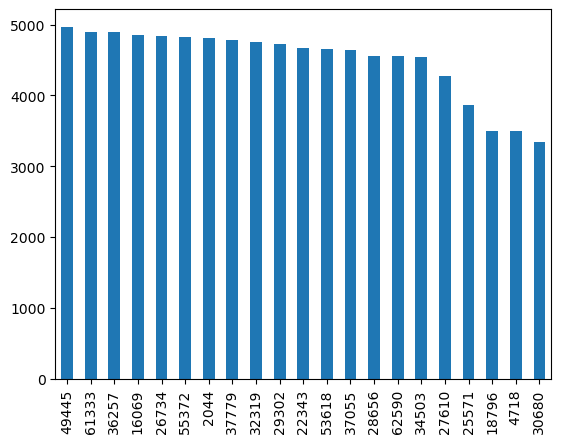

In [6]:
train.participant_id.value_counts().plot(kind="bar")

There are 94477 training samples in total.

In [7]:
len(train)

94477

There are 250 kinds of sign languages that we need to make prediction on.

In [8]:
label_index = read_dict(f"{CFG.data_path}sign_to_prediction_index_map.json")
index_label = dict([(label_index[key], key) for key in label_index])
print(label_index)
train["label"] = train["sign"].map(lambda sign: label_index[sign])
train.head()

{'TV': 0, 'after': 1, 'airplane': 2, 'all': 3, 'alligator': 4, 'animal': 5, 'another': 6, 'any': 7, 'apple': 8, 'arm': 9, 'aunt': 10, 'awake': 11, 'backyard': 12, 'bad': 13, 'balloon': 14, 'bath': 15, 'because': 16, 'bed': 17, 'bedroom': 18, 'bee': 19, 'before': 20, 'beside': 21, 'better': 22, 'bird': 23, 'black': 24, 'blow': 25, 'blue': 26, 'boat': 27, 'book': 28, 'boy': 29, 'brother': 30, 'brown': 31, 'bug': 32, 'bye': 33, 'callonphone': 34, 'can': 35, 'car': 36, 'carrot': 37, 'cat': 38, 'cereal': 39, 'chair': 40, 'cheek': 41, 'child': 42, 'chin': 43, 'chocolate': 44, 'clean': 45, 'close': 46, 'closet': 47, 'cloud': 48, 'clown': 49, 'cow': 50, 'cowboy': 51, 'cry': 52, 'cut': 53, 'cute': 54, 'dad': 55, 'dance': 56, 'dirty': 57, 'dog': 58, 'doll': 59, 'donkey': 60, 'down': 61, 'drawer': 62, 'drink': 63, 'drop': 64, 'dry': 65, 'dryer': 66, 'duck': 67, 'ear': 68, 'elephant': 69, 'empty': 70, 'every': 71, 'eye': 72, 'face': 73, 'fall': 74, 'farm': 75, 'fast': 76, 'feet': 77, 'find': 78, '

,path,participant_id,sequence_id,sign,label
0,train_landmark_files/26734/1000035562.parquet,26734,1000035562,blow,25
1,train_landmark_files/28656/1000106739.parquet,28656,1000106739,wait,232
2,train_landmark_files/16069/100015657.parquet,16069,100015657,cloud,48
3,train_landmark_files/25571/1000210073.parquet,25571,1000210073,bird,23
4,train_landmark_files/62590/1000240708.parquet,62590,1000240708,owie,164


## Create Tensorflow Dataset

In [9]:
def decode_function(record_bytes):
    return tf.io.parse_single_example(
          # Data
          record_bytes,
          # Schema
          {
              "feature": tf.io.FixedLenFeature([CFG.sequence_length * CFG.rows_per_frame * 3], dtype=tf.float32),
              "label": tf.io.FixedLenFeature([], dtype=tf.int64)
          }
      )
def preprocess(item):
    features = item["feature"]
    features = tf.reshape(features, (CFG.sequence_length, 543, 3))
    return features, item["label"]         
def make_dataset(file_paths, batch_size=128, mode="train"):
    ds = tf.data.TFRecordDataset(file_paths)
    ds = ds.map(decode_function)
    ds = ds.map(preprocess)
    options = tf.data.Options()
    if mode == "train":
        ds = ds.shuffle(1024)
        options.experimental_deterministic = False
    ds = ds.batch(batch_size, drop_remainder=True)
    ds = ds.with_options(options) 
    ds = ds.cache().prefetch(tf.data.AUTOTUNE)
    return ds

In [10]:
unique_ids = np.array(sorted(train.participant_id.unique()))
train_ds = make_dataset([f"{CFG.tf_record_path}{identifier}.tfrecords" for identifier in unique_ids[:-4]])
valid_ds = make_dataset([f"{CFG.tf_record_path}{identifier}.tfrecords" for identifier in unique_ids[-4:]], mode="valid")

## Modeling

In [11]:
def conv1d_lstm_block(inputs, filters):
    vector = tf.keras.layers.ConvLSTM1D(filters=32, kernel_size=8)(inputs)
    for f in filters:
        vector = tf.keras.layers.Conv1D(filters=f, kernel_size=8)(vector)
        vector = tf.keras.layers.MaxPooling1D()(vector)
    vector = tf.keras.layers.Dropout(0.3)(vector)
    return vector

def get_model():
    inputs = tf.keras.Input((CFG.sequence_length, 543, 3), dtype=tf.float32)
    face_inputs = inputs[:, :, 0:468, :]
    left_hand_inputs = inputs[:, :, 468:489, :]
    pose_inputs = inputs[:, :, 489:522, :]
    right_hand_inputs = inputs[:, :,522:,:]
    face_vector = conv1d_lstm_block(face_inputs, [32, 64])
    left_hand_vector = conv1d_lstm_block(left_hand_inputs, [64])
    right_hand_vector = conv1d_lstm_block(right_hand_inputs, [64])
    pose_vector = conv1d_lstm_block(pose_inputs, [64])
    vector = tf.keras.layers.Concatenate(axis=1)([face_vector, left_hand_vector, right_hand_vector, pose_vector])
    vector = tf.keras.layers.Flatten()(vector)
    output = tf.keras.layers.Dense(250, activation="softmax")(vector)
    model = tf.keras.Model(inputs=inputs, outputs=output)
    model.compile(
        loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=[
            "accuracy",
        ]
    )
    return model

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 12, 543, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 tf.__operators__.getitem (Slic  (None, 12, 468, 3)  0           ['input_1[0][0]']                
 ingOpLambda)                                                                                     
                                                                                                  
 conv_lstm1d (ConvLSTM1D)       (None, 461, 32)      35968       ['tf.__operators__.getitem[0][0]'
                                                                 ]                            

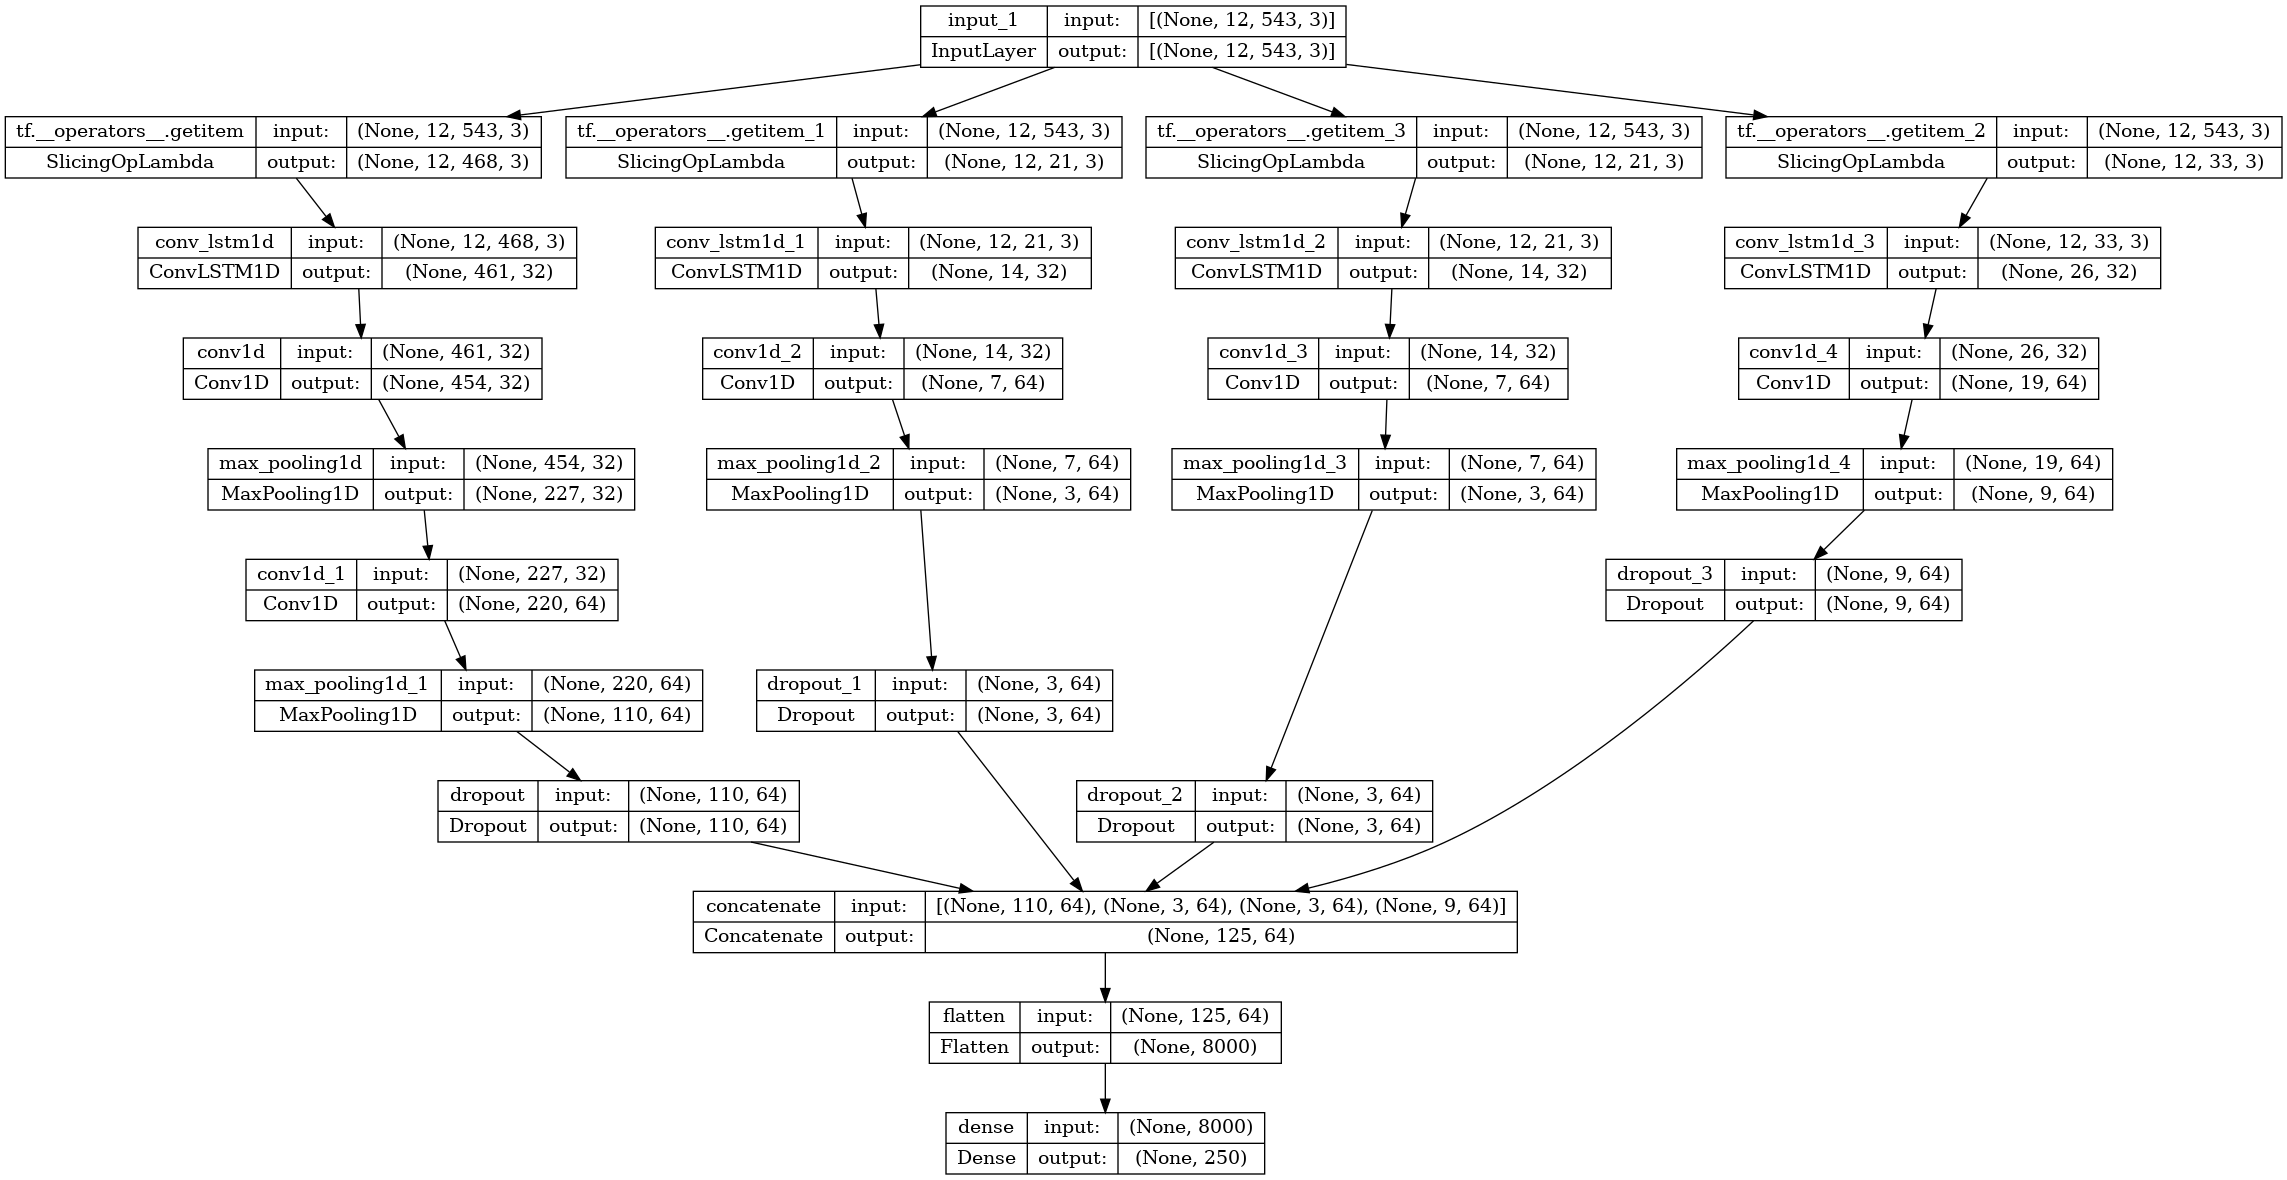

In [12]:
model = get_model()
model.summary()
tf.keras.utils.plot_model(model, show_shapes=True)

In [13]:
if CFG.is_training:
    file_name = "model.h5"
    callbacks = [
        tf.keras.callbacks.ModelCheckpoint(
            file_name, 
            save_best_only=True, 
            restore_best_weights=True, 
            monitor="val_accuracy",
            mode="max"
        ),
        tf.keras.callbacks.EarlyStopping(
            patience=5, 
            monitor="val_accuracy",
            mode="max"
        )
    ]
    model.fit(train_ds, epochs=30, validation_data=valid_ds, callbacks=callbacks)
    model = tf.keras.models.load_model(file_name)
else:
    model = tf.keras.models.load_model("/kaggle/input/islr-convlstm1d/model.h5")
model.evaluate(valid_ds)   

148/148 [==============================] - 131s 875ms/step - loss: 3.0476 - accuracy: 0.4050


[3.0475897789001465, 0.4050358831882477]

## Create Model for inference

In [14]:
def get_inference_model(model):
    inputs = tf.keras.Input((543, 3), dtype=tf.float32, name="inputs")
    vector = tf.image.resize(inputs, (CFG.sequence_length, 543))
    vector = tf.where(tf.math.is_nan(vector), tf.zeros_like(vector), vector)
    vector = tf.expand_dims(vector, axis=0)
    vector = model(vector)
    output = tf.keras.layers.Activation(activation="linear", name="outputs")(vector)
    inference_model = tf.keras.Model(inputs=inputs, outputs=output) 
    inference_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=["accuracy"])
    return inference_model

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, 543, 3)]     0           []                               
                                                                                                  
 tf.image.resize (TFOpLambda)   (12, 543, 3)         0           ['inputs[0][0]']                 
                                                                                                  
 tf.math.is_nan (TFOpLambda)    (12, 543, 3)         0           ['tf.image.resize[0][0]']        
                                                                                                  
 tf.zeros_like (TFOpLambda)     (12, 543, 3)         0           ['tf.image.resize[0][0]']        
                                                                                            

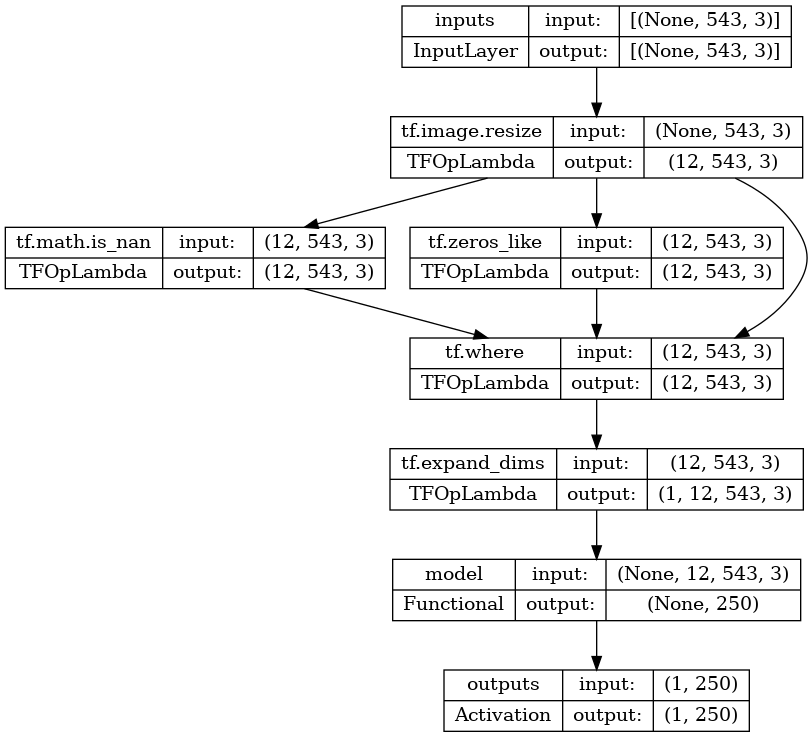

In [15]:
inference_model = get_inference_model(model)
inference_model.summary()
tf.keras.utils.plot_model(inference_model, show_shapes=True)

## Create submission file

In [16]:
converter = tf.lite.TFLiteConverter.from_keras_model(inference_model)
tflite_model = converter.convert()
model_path = "model.tflite"
# Save the model.
with open(model_path, 'wb') as f:
    f.write(tflite_model)
!zip submission.zip $model_path

  adding: model.tflite (deflated 9%)


## Making Predictions

In [17]:
!pip install tflite-runtime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 2.3 MB/s eta 0:00:00


In [18]:
import tflite_runtime.interpreter as tflite
interpreter = tflite.Interpreter(model_path)
found_signatures = list(interpreter.get_signature_list().keys())
prediction_fn = interpreter.get_signature_runner("serving_default")
for i in range(100):
    frames = load_relevant_data_subset(f'/kaggle/input/asl-signs/{train.iloc[i].path}')
    output = prediction_fn(inputs=frames)
    sign = np.argmax(output["outputs"])
    print(f"Predicted label: {index_label[sign]}, Actual Label: {train.iloc[i].sign}")

Predicted label: balloon, Actual Label: blow
Predicted label: wait, Actual Label: wait
Predicted label: cloud, Actual Label: cloud
Predicted label: garbage, Actual Label: bird
Predicted label: green, Actual Label: owie
Predicted label: duck, Actual Label: duck
Predicted label: minemy, Actual Label: minemy
Predicted label: old, Actual Label: lips
Predicted label: flower, Actual Label: flower
Predicted label: drop, Actual Label: time
Predicted label: vacuum, Actual Label: vacuum
Predicted label: apple, Actual Label: apple
Predicted label: ride, Actual Label: puzzle
Predicted label: mitten, Actual Label: mitten
Predicted label: there, Actual Label: there
Predicted label: dryer, Actual Label: dry
Predicted label: dirty, Actual Label: shirt
Predicted label: owl, Actual Label: owl
Predicted label: another, Actual Label: yellow
Predicted label: read, Actual Label: time
Predicted label: jacket, Actual Label: not
Predicted label: vacuum, Actual Label: zipper
Predicted label: clean, Actual Label